In [1]:
import os
import glob
import re
import ants

import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

in_container=True
DATADIR = "/DATA" if in_container else "/BEE/Connectome"
raw_data_path = "/ASD2/ahsan_projects/datasets/MSLUB/"
processed_data_path = f"/{DATADIR}/Users/amahmood/braintyp/"
segs_dir = f"/{DATADIR}/Users/amahmood/braintyp/segs/"

In [4]:
%ls -ailh $processed_data_path | grep MSLUB | head

15071487318 -rw-r--r--.  1 amahmood 1001 8.4M Oct 31 19:29 MSLUB01.nii.gz
15071487320 -rw-r--r--.  1 amahmood 1001  55K Oct 31 19:29 MSLUB01_label.nii.gz
15071487321 -rw-r--r--.  1 amahmood 1001 9.2M Oct 31 19:30 MSLUB02.nii.gz
15071487322 -rw-r--r--.  1 amahmood 1001  29K Oct 31 19:30 MSLUB02_label.nii.gz
15071487323 -rw-r--r--.  1 amahmood 1001 7.4M Oct 31 19:32 MSLUB03.nii.gz
15071487324 -rw-r--r--.  1 amahmood 1001  29K Oct 31 19:32 MSLUB03_label.nii.gz
15071487325 -rw-r--r--.  1 amahmood 1001 9.7M Oct 31 19:33 MSLUB04.nii.gz
15071487326 -rw-r--r--.  1 amahmood 1001  51K Oct 31 19:33 MSLUB04_label.nii.gz


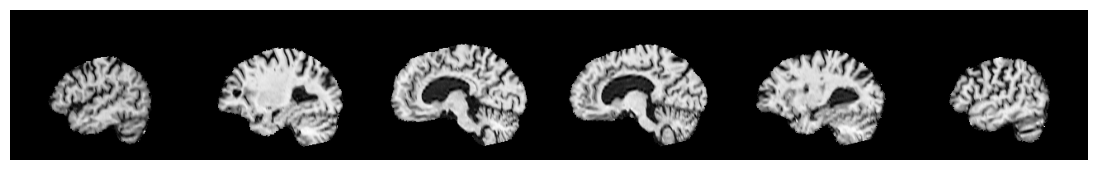

In [3]:
img,_ = ants.image_read(f"{processed_data_path}/mslub-hist-m2/MSLUB01.nii.gz").split_channels()
# seg = ants.image_read(f"{processed_data_path}/MSLUB01_label.nii.gz")
img.plot(nslices=6)

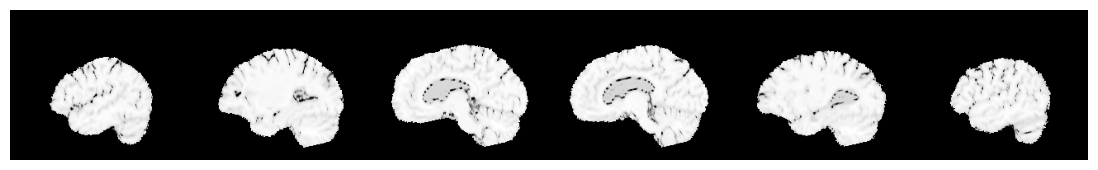

In [8]:
t1img,_ = ants.image_read(f"{processed_data_path}/mslub-hist-m5/MSLUB01.nii.gz").split_channels()
# seg = ants.image_read(f"{processed_data_path}/MSLUB01_label.nii.gz")
t1img.plot(nslices=6, scale=(0.001, 0.999))

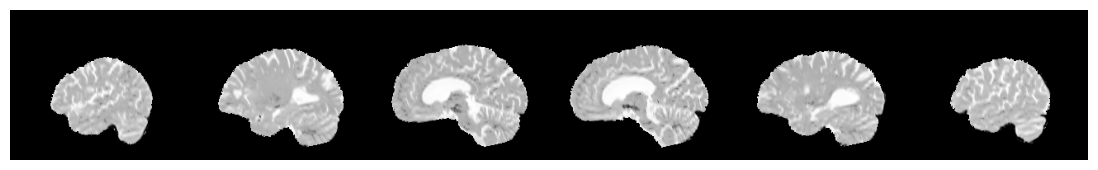

In [6]:
_,img = ants.image_read(f"{processed_data_path}/mslub-hist-m5/MSLUB01.nii.gz").split_channels()
# seg = ants.image_read(f"{processed_data_path}/MSLUB01_label.nii.gz")
img.plot(nslices=6)

### WM Segmentations fail, so we can use simple heuristics

In [35]:
img_paths = glob.glob(f"{processed_data_path}/MSLUB*[0-9].nii.gz")
subids = [re.search(r"(MSLUB.*)\.nii", p).group(1) for p in img_paths]
len(img_paths), img_paths[0], subids[0]

(7, '//DATA/Users/amahmood/braintyp/mslub/MSLUB01.nii.gz', 'MSLUB01')

In [12]:
%%time
t1_means, t1_stds = [], []
t2_means, t2_stds = [], []

for p in tqdm(img_paths):
    img = ants.image_read(p)
    t1,t2 = img.split_channels()
    t1_means.append(t1.mean())
    t1_stds.append(t1.std())

    t2_means.append(t2.mean())
    t2_stds.append(t2.std())

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

CPU times: user 3.44 s, sys: 161 ms, total: 3.6 s
Wall time: 3.78 s


In [13]:
t1_wm_means = pd.Series(t1_means, index=subids)
t2_wm_means = pd.Series(t2_means, index=subids)

<Axes: >

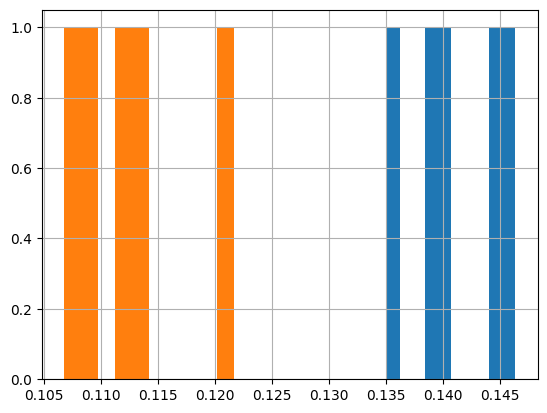

In [14]:
t1_wm_means.hist()
t2_wm_means.hist()

In [15]:
t1_wm_stds = pd.Series(t1_stds, index=subids)
t2_wm_stds = pd.Series(t2_stds, index=subids)

<Axes: >

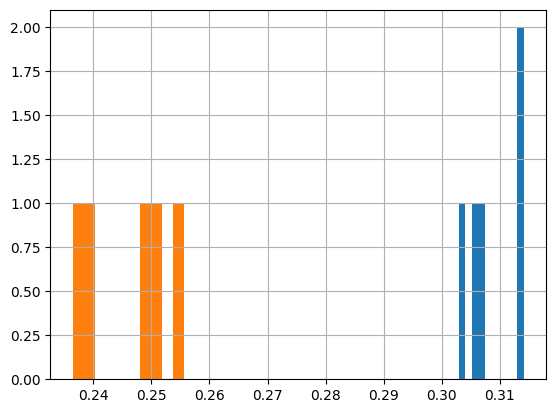

In [16]:
t1_wm_stds.hist()
t2_wm_stds.hist()

In [17]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.141 w/ std 0.004


In [18]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.309 w/ std 0.005


In [21]:
mult = 3
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

0

In [22]:
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

5

In [23]:
for tidx in t1_outliers[:4]:
    sid = t1_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")

    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

### T2

In [24]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [25]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.113 w/ std 0.006


In [26]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.246 w/ std 0.008


In [27]:
mult = 2
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

0

In [28]:
for tidx in t2_outliers[:4]:
    sid = t2_wm_means.index[tidx]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")
    
#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))    
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

In [29]:
t1_drop_samples = t1_wm_means.index[t1_outliers].to_list()
t2_drop_samples = t2_wm_means.index[t2_outliers].to_list()
drop_samples = set(t1_drop_samples).union(set(t2_drop_samples))
len(drop_samples)

0

In [30]:
len(t1_wm_means)

5

In [31]:
keep_samples = t1_wm_means.drop(index=drop_samples).index.to_list()
len(keep_samples)

5

In [32]:
brats_gli_passing_keys = pd.Series(keep_samples)
brats_gli_passing_keys.to_csv('../split-keys/mslub_keys.txt', header=None, index=None)